# Problem Statement :AllLife Bank Customer Segmentation

##Contenxt 
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

 

##Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

 



# Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

## Data Dictionary

1. Sl_No: Primary key of the records

2. Customer Key: Customer identification number
3. Average Credit Limit: Average credit limit of each customer for all credit cards
4. Total credit cards: Total number of credit cards possessed by the customer
5. Total visits bank: Total number of visits that customer made (yearly) personally to the bank
6. Total visits online: Total number of visits or online logins made by the customer (yearly)
7. Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)
 

#Import Necessary Libraries

In [196]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns

from sklearn.preprocessing  import StandardScaler,MinMaxScaler

## For using KMean clusters 
from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_score

## For Visualization of clusters created using KMean
from yellowbrick.cluster import  KElbowVisualizer,SilhouetteVisualizer

##  cluster wise distance and pairwise distance calculation
from scipy.spatial.distance import cdist,pdist
# For calculating Zscore 
from scipy.stats import zscore


## For Hierachical Clustering 
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage


# Read data and create Copy

In [197]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [198]:
data =pd.read_excel('/content/drive/MyDrive/CreditCardCustomerData.xlsx')

# Exploratory Data Analysis

In [199]:
data.dtypes

Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

In [200]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [201]:
data.duplicated().sum()

0

In [202]:
data.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [203]:
data.describe(include='all').round(2).T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.50,190.67,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.44,25627.77,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.24,37625.49,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.71,2.17,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.40,1.63,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.61,2.94,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.58,2.87,0.0,1.00,3.0,5.00,10.0


Looking at data statistics,
1. we can see that there are total 660 rows and 7 columns .
2. There are no null or duplicates in this data set .
3. Column SI _No and Customer Key are id and customer Number column which we can drop when we will start data analysis 
4. Aveerage Credit Card Limit  of all cards hold by Customer are  roughly 34,574 with median around 18,000 which means data is right skewed .
5. Most of customers are having average 4 to 5 creadit cards 
6. Average visit to Banks is 2 with maximum times custmer visited bank is 5 
7. Avrange times customer visisted online stire is also similar to their in paerson visition that is 2 to 3 but maximum time customer has visited Bank site online is 15 .
8. Average customers make 3 calls to Bank. However we can see that maximum calls made are 10 .
9. We can further evaluate Customers Interaaction with Bank .




In [204]:
###  We can ignore SI NO and Customer Key as they are unique id and customer identification number 
customerData=data.iloc[:,2:].copy()

'''As we can see Average Credit Limit is highly skewed whereas Total credit card , total vistis to Bank , Total online vistis and Total calls are slightly right skwewed . 
as we know in Kmean we use Euclidean distance which has high impact if the data is skewed /has outliers .
let us first check for outliers '''

In [205]:
# This Function will  use to  Plot Histplot and Box Plot for all numberical columns  . We will add Lines to show mean and Median 
# so we can check skewness of data . 
# we will pass data Frame and column name as variables 
def checkDistribution(dataframe,columnName):
     plt.figure(figsize=(12,7));
     plt.subplot(1,2,1)
     plt.title("Distribution for Variable "+ columnName, fontsize=15)
     sns.histplot(data=dataframe,x=columnName,kde=True ,bins=15)
     plt.axvline(np.mean(dataframe[columnName]), color='green', linestyle='--') # Add mean to the histogram
     plt.text(np.mean(dataframe[columnName])+0.15,30,'Mean = '+str(round(np.mean(dataframe[columnName]),1)),rotation=90, fontsize=12)
     plt.axvline(np.median(dataframe[columnName]), color='red', linestyle='-') # Add median to the histogram
     plt.text(np.median(dataframe[columnName])+0.15,30,'Median = '+str(round(np.median(dataframe[columnName]),1)),rotation=90, fontsize=12)
     # To plot Bolxplot and showing Mean value
     plt.subplot(1,2,2)
     plt.title("Boxplot for "+ columnName, fontsize=12)
     sns.boxplot(data=dataframe,x=columnName ,showmeans=True )

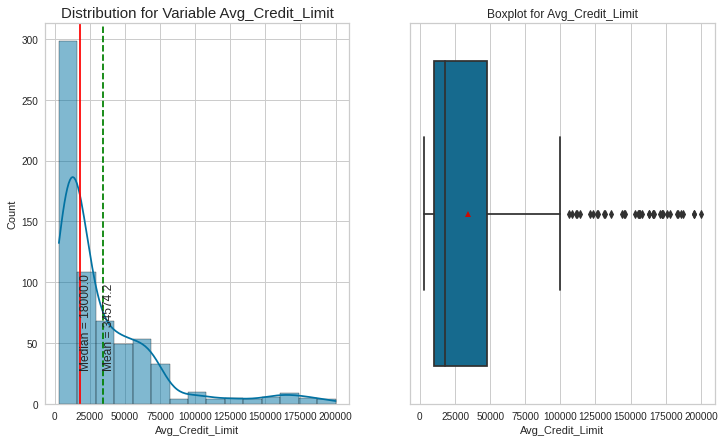

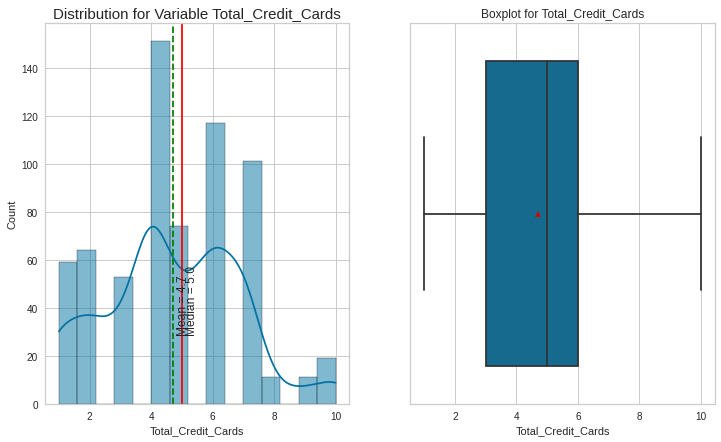

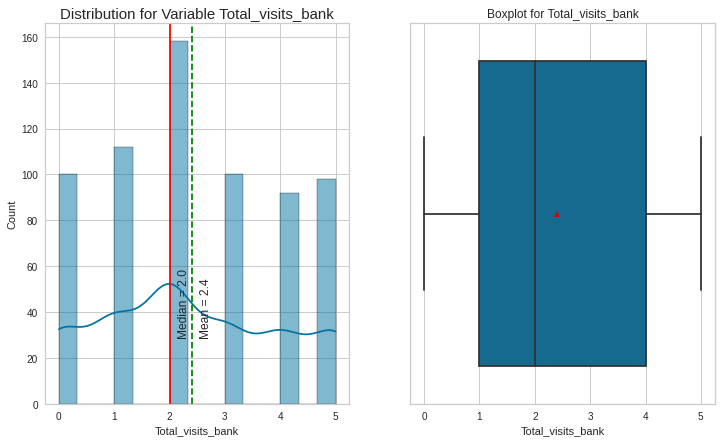

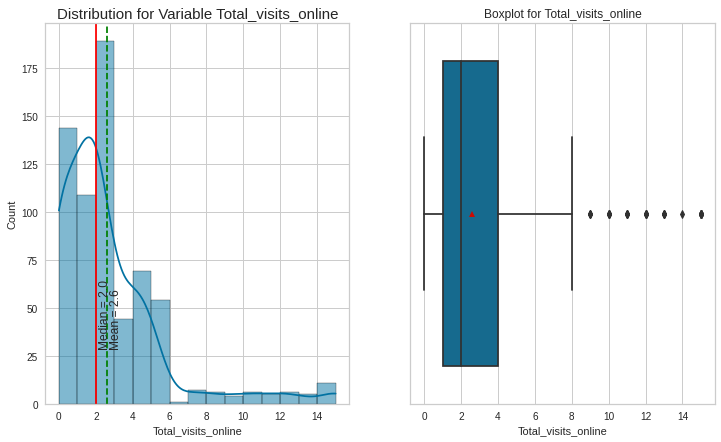

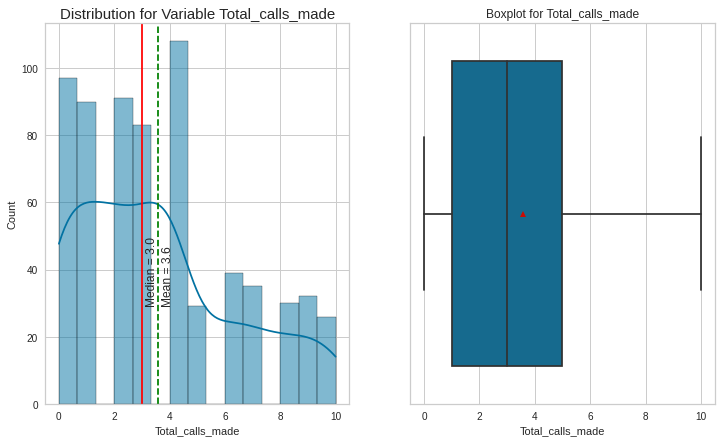

In [206]:
# selecting numerical columns
num_col=customerData.select_dtypes(include=np.number).columns.tolist()
for item in num_col:
    checkDistribution(customerData, item)

Based on above histogram and Box Plot we can see  we have outliers in Avg credit Limit and number of online Visits .

There is right skewed data for Averange credit Limit but as we can see there are certain set of customers with  max credit limit and rest within averange range .So directly treating  the outliers might be inappropriate  .
 First we will heck Averange Credit limit based on number of credit cards the customer has so we can know if this is genuine data or real outliers .


In [207]:
df=customerData.groupby('Total_Credit_Cards')

In [208]:
df.mean()

,Avg_Credit_Limit,Total_visits_bank,Total_visits_online,Total_calls_made
Total_Credit_Cards,,,,
1,11457.627119,0.932203,3.491525,7.220339
2,13187.500000,0.921875,3.531250,6.515625
3,13301.886792,0.867925,3.698113,6.641509
4,26311.258278,2.768212,1.728477,3.529801
5,34689.189189,3.256757,1.216216,2.135135
6,33205.128205,3.555556,1.162393,1.914530
7,44495.049505,3.207921,1.584158,2.099010
8,139454.545455,0.636364,9.272727,0.818182
9,140090.909091,0.727273,11.272727,1.272727


1. We can see that as number of credit cards increases  Average Credit Limit also increases .
2. Most of the customers with more number of credit cards and having  high avg Credit  limit are visting online site more than other customers .
3. Customers with credits from from 4 to 7 have avg limit arounf 26000 to 44000 and they are making more in person visits to Bank .
4. Customers with less than 4 creadti cards and credit limit around 10000 to 13000 are giving maximum calls  to Bank .
5. This information  suggests that there can be minimum 3 different type of Customer Behaviour and it might lead to 3 Customer cluster . 


In [209]:
df=customerData.groupby('Total_visits_bank' ,sort=True)['Avg_Credit_Limit']

In [210]:
df.mean()

Total_visits_bank
0    39150.000000
1    47544.642857
2    26050.632911
3    35300.000000
4    33000.000000
5    29561.224490
Name: Avg_Credit_Limit, dtype: float64

In [211]:
customerData[customerData['Avg_Credit_Limit']>100000]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
612,157000,9,1,14,1
614,163000,8,1,7,1
615,131000,9,1,10,1
617,136000,8,0,13,0
618,121000,7,0,13,2
619,158000,7,0,13,0
620,108000,10,0,15,1
621,166000,9,1,12,2
622,176000,10,1,15,2
623,166000,10,0,7,0


We can we people having more credit cards are having  more avg credit card limit .So we will not treat avg credit limit outliers .

In [212]:

def createbarPlot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

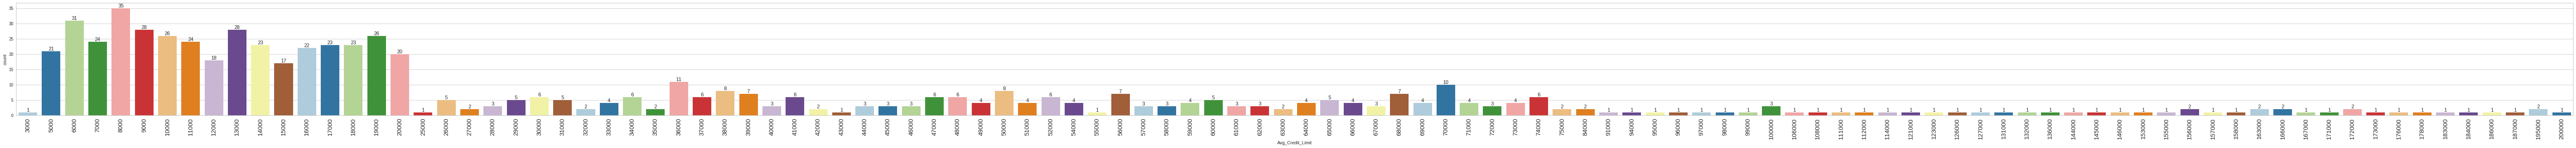

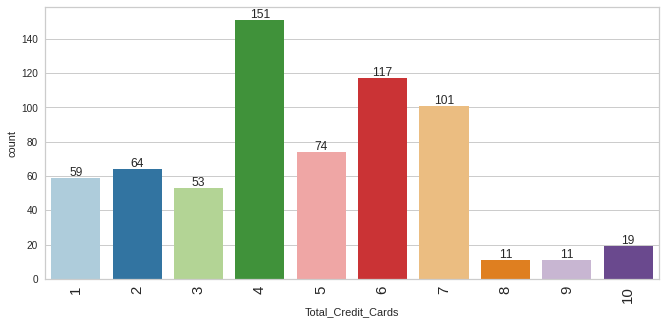

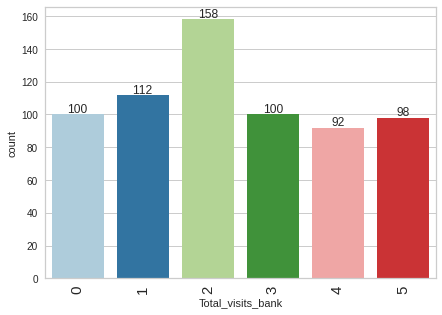

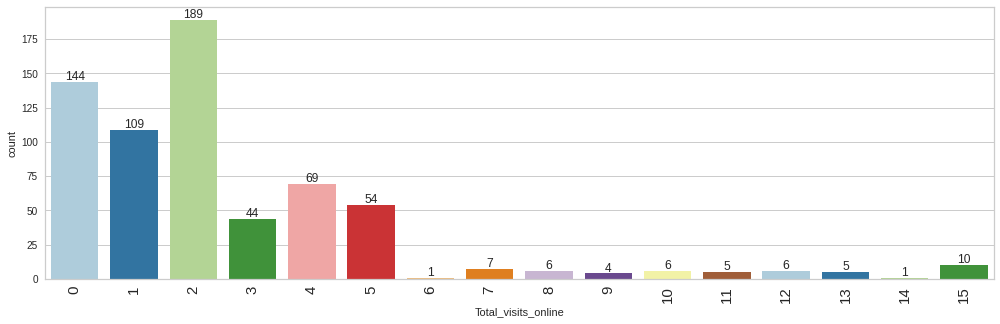

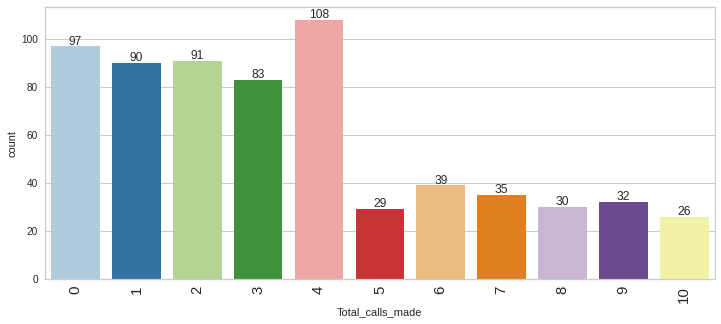

In [213]:
for item in num_col:
    createbarPlot(customerData, item)

We can see ,


1.  Most of the customers have 4 credit cards and  many have visited bank twice
2.  Maximum customers are from group who have  called bank 4 times . 
3. There is large variation in avg credit card limit 
4. maximum Customers have visited online site  roughly 2 times .

# BiVariate Analysis

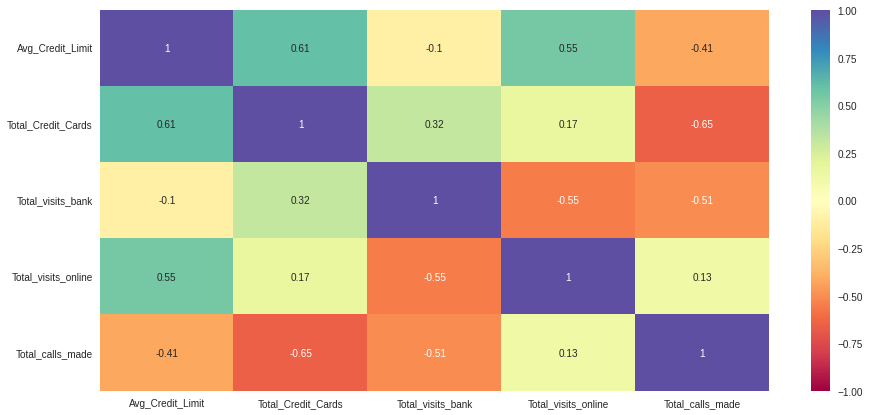

In [214]:
plt.figure(figsize=(15,7))
sns.heatmap(customerData.corr(),annot=True,vmin=-1,vmax=1,cmap="Spectral",cbar=True)
plt.show()

There is negative co -relation  between Totoal Visits online and Total visit to Bank. As it is evident that people who try to interact with one mode try to use other option less freqnetly .
Also There is positive co-relation between number fo creadit cards and Ave credit Limit as number of cards increases credit limit is more .

#Feature Scaling 

### **What is feature scaling?**

Feature scaling is a class of statistical techniques that, as the name implies, scales the features of our data so that they all have a similar range. 

### **Why feature scaling is improtant in Unsupervised Learning?**

Feature scaling is specially relevant in machine learning models that compute some sort of distance metric, like most clustering methods like K-Means. 

So, scaling should be done to avoid the problem of one feature dominating over others because the unsupervised learning algorithm uses distance to find the similarity between data points.

## **CustomerData Set why we need to do scaling**
   In Out data set  total credit cards , total visits to bank , total online , total call made are all numeric data with range 1 to 10 but Avg Credit Card has value from  34,000 to 200,000 . in Cluster formation and checking we take into accout distance and as the values in avg credit card are much higher than all columns so will be the distance between any two data points for this feature . 
Hence to khave equal weightage to all feature we should do Feature scaling .and we will use Zscore for it . 

## Zscore  is (x-xmean)/standard deviation

In [215]:
customerDataScaled=customerData.apply(zscore)

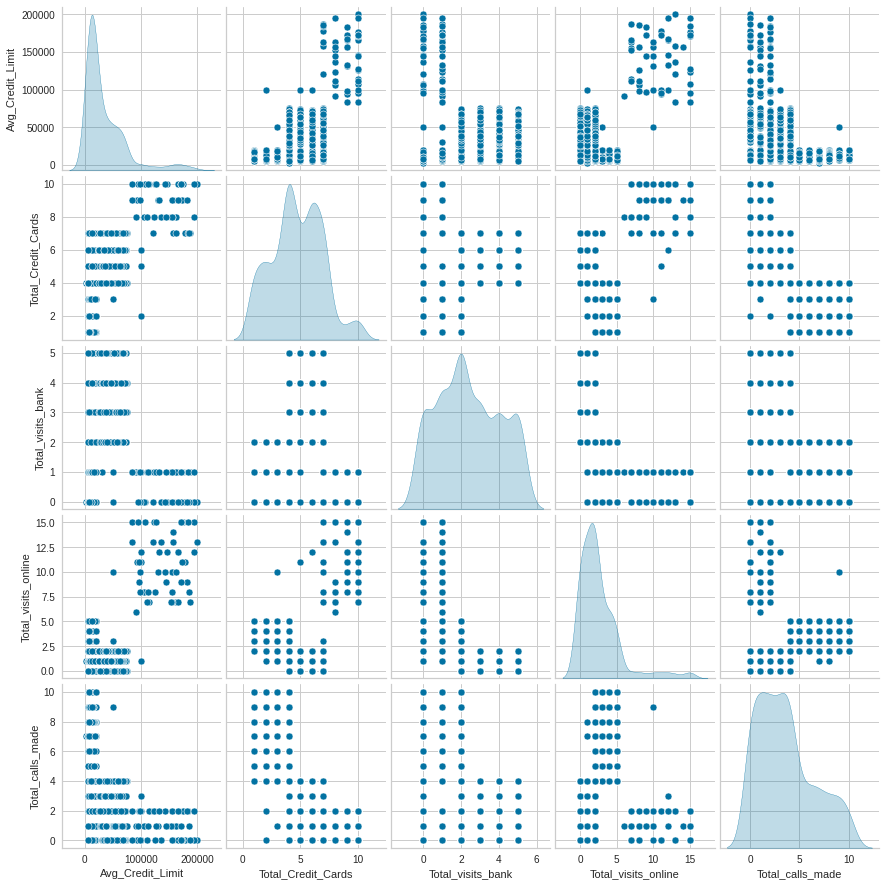

In [216]:
sns.pairplot(data=customerData,diag_kind='kde')

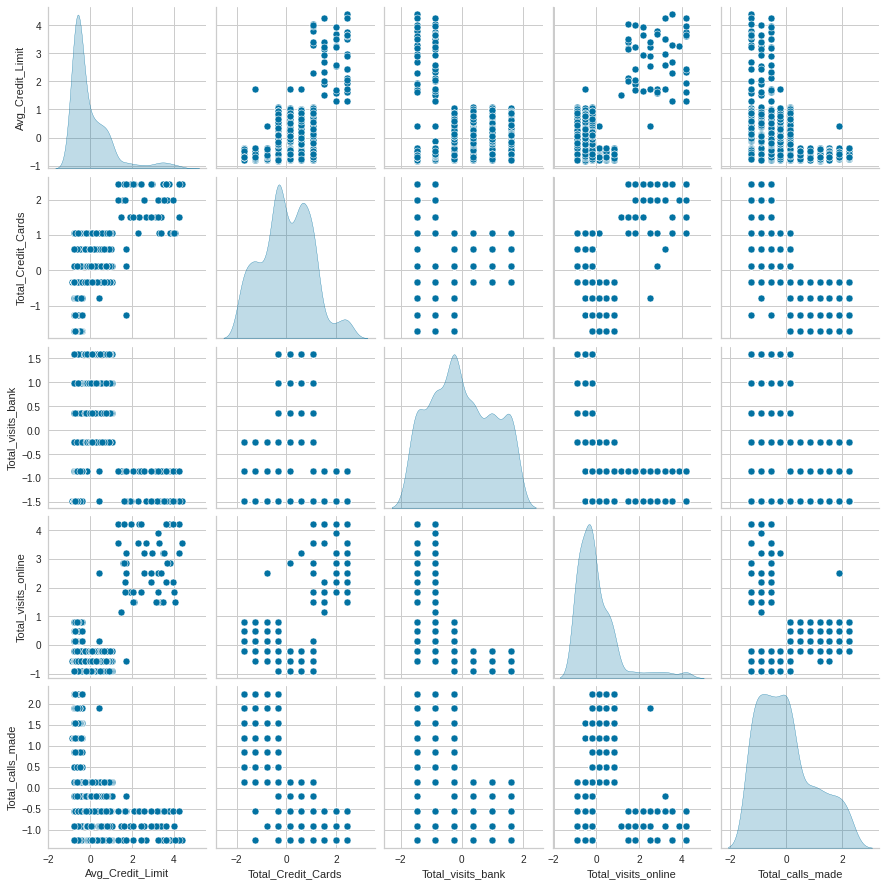

In [217]:
sns.pairplot(data=customerDataScaled,diag_kind='kde')

##**Observation**
Looking at the Pair plot for total Creadit cards we can see roughly there can be four clusters . 
Looking at visits to Bank we can see there can be 4 to 6 clusters .
This information we can use to come up with inital K for Kmean.

# Clustering 



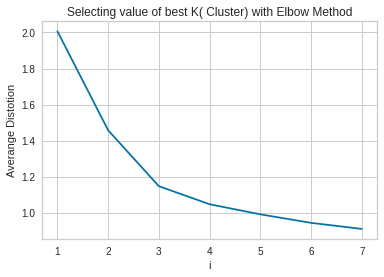

In [218]:
clusters = range (1,8)
meanDistortions=[]

for i in clusters :
  model=KMeans(n_clusters=i)
  model.fit(customerDataScaled)
  prediction=model.predict(customerDataScaled)
  meanDistortions.append(sum(np.min(cdist(customerDataScaled,model.cluster_centers_,'euclidean'),axis=1))/customerDataScaled.shape[0])
plt.plot(clusters,meanDistortions,'bx-')
plt.xlabel('i')
plt.ylabel('Averange Distotion')
plt.title( 'Selecting value of best K( Cluster) with Elbow Method')
plt.show()


**We can see that there is sharp turn on cluster 2 , 3 and 4 so probabably we can have  cluster  in range 3 to 5 .**


**To make a better decision about the number of clusters, we can look at the silhouette score for different K values.**

# Silhouette Score 

Silhouette score is one of the methods for evaluating the quality of clusters created using clustering algorithms such as K-Means. The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Silhouette score has a range of [-1, 1].

Silhouette coefficients near +1 indicate that the sample is far away from the neighboring clusters.
Silhouette score near -1 indicate that those samples might have been assigned to the wrong cluster.

For Number of  Cluster =2 ,silhoutte score is 0.41842496663215445
For Number of  Cluster =3 ,silhoutte score is 0.5157182558881063
For Number of  Cluster =4 ,silhoutte score is 0.3556670619372605
For Number of  Cluster =5 ,silhoutte score is 0.2717470361089752
For Number of  Cluster =6 ,silhoutte score is 0.25545029453623114


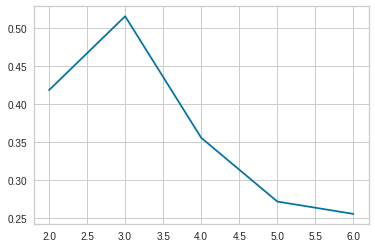

In [219]:
from yellowbrick import cluster
score_silhouette=[]
cluster_list=list(range(2,7))## as we have seen  from elbow curve max we can have 6 to 7 clusters so take range from  2to 7 
for counter in cluster_list:
  clusterer = KMeans(n_clusters=counter)
  preds= clusterer.fit_predict(customerDataScaled)
  score= silhouette_score(customerDataScaled,preds)
  score_silhouette.append(score)
  print ("For Number of  Cluster ={} ,silhoutte score is {}".format(counter,score))
plt.plot(cluster_list,score_silhouette)

**From the silhouette scores, it seems that 3 is a good value of k.Let's do deeper investigation for different K values using  SilhouetteVisualizer**

# How to Check Silhouette Score 

Below are the points that every cluster needs to satisfy for selecting the optimal K-value.
  - There should be no negative silhouette coefficent value
  - All the clusters should cross the avg silhouette score
  - All the clusters should have the different variations (width)
  - All the clusters should have different silhouette score
  
**Note** 
1. Width of each cluster refers to the size of each cluster. (Number of data points present in each cluster)
2. Horizontal line refers to the Silhouette score of each cluster.
3. Dotted red line is an Average Silhouette score. 

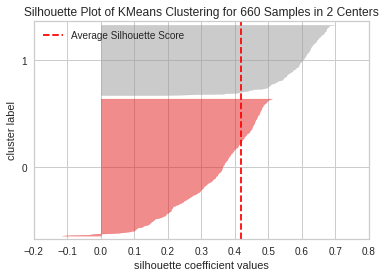

In [220]:
# finding optimal no. of clusters with silhouette coefficients First let us try with 2 clusters 
visualizer = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer.fit(customerDataScaled)
visualizer.show()



1.  We can see that both Clusters have Positive Silhoutte Score 
2.  Both Clusters pass Avg Silhoutte score line 
3. Both have variations as width is different 

But Avg Silhoutte schore is low , let us ty with 3 Clusters .



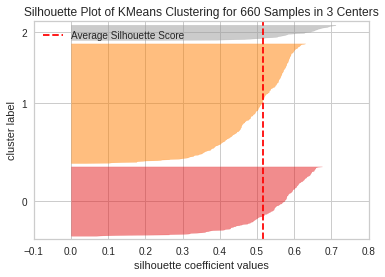

In [221]:

## Let us try with  3 clusters 
visualizer=SilhouetteVisualizer(KMeans(3,random_state=1))
visualizer.fit(customerDataScaled)
visualizer.show()



1.   We can see that all the three clusters  have positive Silhoutte score 
2.  We can see that all the 3 clusters cross avg Silhoutte score 
3. All the 3 Clusters have different width 
4. Avg Silhoutte schore is 0.55 

This seems to  be good Cluster size but let us try with 4 Cluster size to ensure our choice .




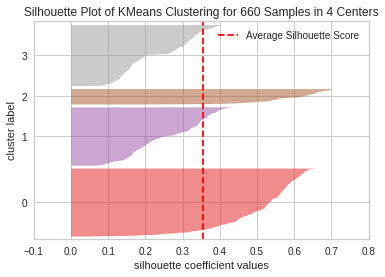

In [222]:
## Let us try with 4 Clusters 

visualizer=SilhouetteVisualizer(KMeans(n_clusters=4,random_state=1))
visualizer.fit(customerDataScaled)
visualizer.show()


1.  Here we can see average Silhoutte score is less 
2.  Cluster 1 and Cluster 3 have same width  
3.   Cluster 1 and 3 both  pass Average Silhoutte score line at similar distance , which means both these clusters are very similar . 

Hence choice of 4 clusters is not good and we should stick with Cluster size of 3 .


#  Final KMEAN Model using Cluster size 3

In [223]:
final_model=KMeans(3 ,random_state=1)
final_model.fit(customerDataScaled)


KMeans(n_clusters=3, random_state=1)

In [224]:
## Let us add Cluster details in Original as well as Scaled  Data Frame
customerData['label']=final_model.labels_
customerDataScaled['label']=final_model.labels_

# Cluster Profiling

In [225]:
## Let us group by label which is cluster number  and see  how data is distributed across clusters.
customerDataCluster=customerData.groupby(['label']).mean()


In [226]:
customerDataCluster

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
label,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536
1,33782.383420,5.515544,3.489637,0.981865,2.000000
2,141040.000000,8.740000,0.600000,10.900000,1.080000


In [227]:
customerDataCluster['LabelCount']=customerData.groupby(['label'])['Total_Credit_Cards'].count().values

In [228]:
# let's display cluster profiles
customerDataCluster.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,LabelCount
label,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


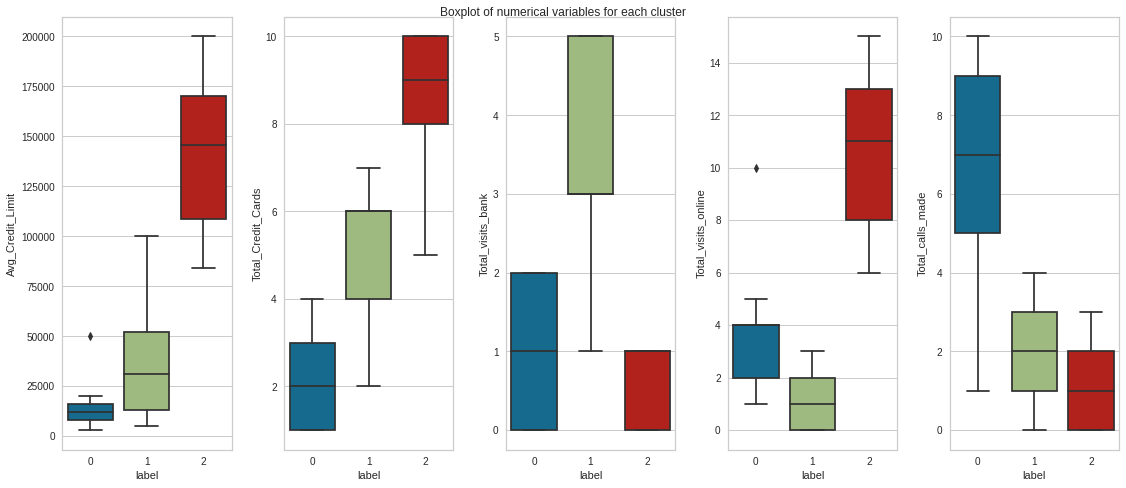

In [229]:
## we have 5 Numberical variables so we will plot 5 subplots to see distribution of data in these clusters .
fig, axes = plt.subplots(1, 5, figsize=(16, 7))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0

for ii in range(5):
    sns.boxplot(ax=axes[ii], y=customerData[num_col[counter]], x=customerData['label'])
    counter = counter + 1

fig.tight_layout(pad=2.0)

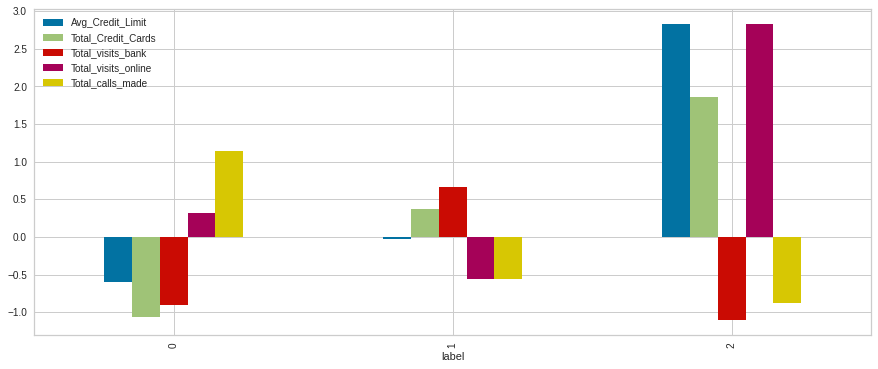

In [230]:
customerDataScaled.groupby("label").mean().plot.bar(figsize=(15, 6))

In [231]:
# let's display cluster profiles
customerDataCluster.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,LabelCount
label,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50



 ## Insights 
 We can see that all the three clusters are clearly different ,
1. Cluster 0 has mimimum avg credit limit of 12174 and Cluster 1 have avg credit limit as 33782 and Cluster 2 has customers with maximum avg credit limit of 141040 . 
2 .  Cluster 2 has customers with maximum credit cards followed By Cluster 1 and Cluster 0 respectively.
3.  There are few customers in Cluster 2 as comapred to Cluster 1 and 2 with Cluster 1 has maximum customers .
4.  Customers From Cluster 2 prefer to visit online as compared to in person or call .   



#  Clustering using Hierarchical Clustering Approach (AgglomerativeClustering)

**Let us First try with Linkage method as Average using Distance as Eucledian**

**Let us see  if  by trying with 4 Clusters .**

In [232]:
agglomerativemodel= AgglomerativeClustering(n_clusters=4,linkage="average",affinity="euclidean" )


In [233]:
customerDataScaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Avg_Credit_Limit     660 non-null    float64
 1   Total_Credit_Cards   660 non-null    float64
 2   Total_visits_bank    660 non-null    float64
 3   Total_visits_online  660 non-null    float64
 4   Total_calls_made     660 non-null    float64
 5   label                660 non-null    int32  
dtypes: float64(5), int32(1)
memory usage: 28.5 KB


As we have already added Label field( Cluster Number in Customer Data and Scaled Data we will just take copy of data excluding this column and use it for Modelling Agglomerative Model.

In [234]:
customerDataScaledForAM=customerDataScaled.iloc[:,:-1]
customerDataForAM=customerData.iloc[:,:-1]

In [235]:
customerDataScaledForAM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Avg_Credit_Limit     660 non-null    float64
 1   Total_Credit_Cards   660 non-null    float64
 2   Total_visits_bank    660 non-null    float64
 3   Total_visits_online  660 non-null    float64
 4   Total_calls_made     660 non-null    float64
dtypes: float64(5)
memory usage: 25.9 KB


In [236]:
customerDataForAM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


In [237]:
agglomerativemodel.fit(customerDataScaledForAM)

AgglomerativeClustering(linkage='average', n_clusters=4)

In [238]:
customerDataForAM['labelswithAM'] = agglomerativemodel.labels_


In [239]:
customerDataForAM.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labelswithAM
0,100000,2,1,1,0,3
1,50000,3,0,10,9,0
2,50000,7,1,3,4,2
3,30000,5,1,1,4,2
4,100000,6,0,12,3,1
5,20000,3,0,1,8,0
6,100000,5,0,11,2,1
7,15000,3,0,1,1,0
8,5000,2,0,2,2,0
9,3000,4,0,1,7,0


In [240]:
customerDataClusterAM= customerDataForAM.groupby(['labelswithAM']).mean()

In [241]:
customerDataClusterAM['AM_label_counts']=customerDataForAM.groupby(['labelswithAM'])['Total_Credit_Cards'].count().values

In [242]:
customerDataClusterAM.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,AM_label_counts
labelswithAM,,,,,,
0,12197.309417,2.403587,0.928251,3.560538,6.883408,223
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,33541.450777,5.520725,3.492228,0.984456,2.010363,386
3,100000.000000,2.000000,1.000000,1.000000,0.000000,1


# Observation
**Looking at cluster Profile we can see that Cluser 3 has only one data point also there Cluser 0 ,1 and 2 explains variability well in terms of Avg Credit Limit , Total creadit cards , visit to Bank ,online and call . But Cluster 3 does not exhibit such behaviour.We will again build Model using 3 clusters .** 

#  Hierachical Clustering using n= 3 

In [243]:
## as we had added labels from Previous Model we will drop it from our Customer Data first
customerDataForAM.drop('labelswithAM',axis=1,inplace=True)

In [244]:
## Agglomerative Model  using n=3 
agglomerativemodel= AgglomerativeClustering(n_clusters=3,linkage="average",affinity="euclidean" )

In [245]:
agglomerativemodel.fit(customerDataScaledForAM)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [246]:
## Adding Cluster details in Original Customer Data Frame 
customerDataForAM['labelswithAM']=agglomerativemodel.labels_

In [247]:
## Creating New data Frame for  Profiling 
customerDataClusterAM_3=customerDataForAM.groupby('labelswithAM').mean()

In [248]:
customerDataClusterAM_3['AM_label_counts']=customerDataForAM.groupby(['labelswithAM'])['Total_Credit_Cards'].count().values

In [249]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

Z= linkage(customerDataScaledForAM,metric='euclidean',method='average')
c,coph_dists =cophenet(Z,pdist(customerDataScaledForAM))

In [250]:
c

0.8977080867389372

We are getting good Cophenetic score of 0.89  with Linkage as Euclidean and averange distance method .  

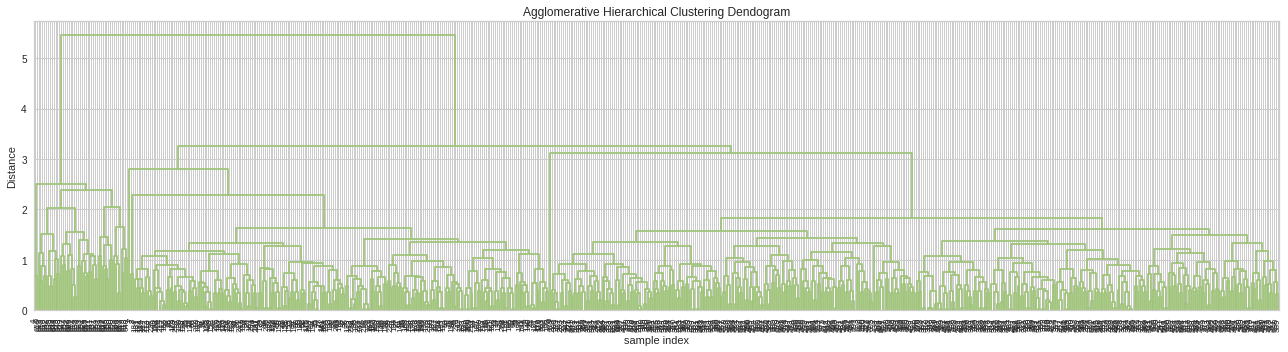

In [251]:
plt.figure(figsize=(18, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

**Let us   try to Check Cophenetic score with Euclidean and complete distance  ( Maximum Distance )method .**

In [252]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

Z = linkage(customerDataScaledForAM, metric='euclidean', method='complete')
c, coph_dists = cophenet(Z , pdist(customerDataScaledForAM))

c

0.8599730607972423

Cophenetic score is 0.85 which is still good 

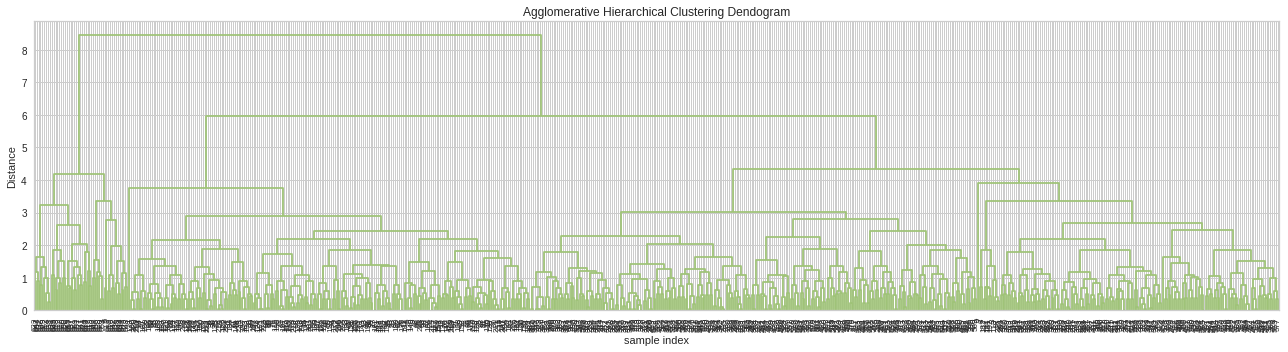

In [253]:
plt.figure(figsize=(18, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

**Let us check Cophenetic score with Eucledian and ward method ( distance between centriod)**

In [254]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering

Z = linkage(customerDataScaledForAM, metric='euclidean', method='ward')
c, coph_dists = cophenet(Z , pdist(customerDataScaledForAM))

c

0.7415156284827493

We are getting low Cophenetic Score as compared to previous two metrics .

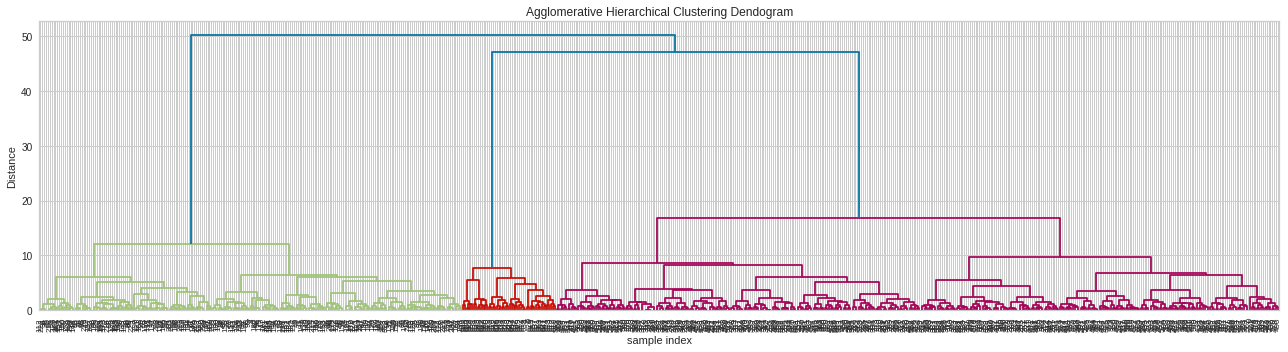

In [255]:
plt.figure(figsize=(18, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8. )
plt.tight_layout()

# Cluster Comparision Between KMean and Hierachical - AgglomerativeClustering

In [256]:
## Customer Data using Kmean Clustering 
customerDataCluster.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,LabelCount
label,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


In [257]:
## Customer Data using Hierachical Clustering 
customerDataClusterAM_3.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,AM_label_counts
labelswithAM,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,223


## Insights :

1.  We can see that Hierachical and KMean both Clustering Techniques gives similar results .
2.  People having High credit limit beong to a cluster which has more number of cards  and such customer are less as compared to other .
3. Most Customers belong to a Cluster with Average Credit Limit around 33,000 and they prefer either visit bank  .
4. Customers with low average creadit Limit of around 12,000 prefer to cotact bank by Call  istead of Visiting Bank.



#  Business Recommendations

1. Both KMean and Hierachical Clustering Technique has given us clusters with maximum customers who have average credit limit around 33,000. 
These customers prefer to Visiting or call Bank rather than doing online Banking .
It might be the case that these customers are not finding online interface that much intutive so bank should contact such customers and check what problems they are facing/ what are their challenges in online Banking.


2. If we check averange number of Credit Cards held by Customers in Cluster 0(which has maximum Customer) are 5 credit cards which is not that as small as compared to Customers in Cluster 1 who have 8 avg. number of credit cards. But if we compare Average Credit limit between these two Clusters then it is way off. Cluster 0 has average Credit Limit around 33,000 whereas Cluster 1 has average Credit Limit around 141,040.
It might be the case that Customers in Cluster 1 are not yet offered increase in their Credit Limit.
Bank should check Customers in Cluster 0 and see if they can increase their Avg Credit Limit.

3. There are small number of Customers in Cluster which has high avg credit limit  and more credit cards and these Customers  prefer online Banking over other modes .Also Calls Made are  least for these .So these Customers should be contacted to offer new products and serverices .

4. There are  second most majority Customers  lies in Cluster with avg credit Limit on lower side of around 12,000 and have rouhgly 2 cards . They moderately visit bank but do call often . So new products additional credit cards  can be proposed to them based on their requirement .



